# HHDriveright TSP Data Quality Assessment (SS, Oct 2021)

In [1]:
# Import libraries
import numpy as np
import pandas as pd
import datetime
import getpass
import psycopg2
import os
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors
# from tqdm import tqdm
import seaborn as sns

# 1. HHDriveright Data

In [5]:
# Define variables
hhdriveright_data_path = '/Users/sven.sabas/projects/tsp-evaluation-framework/data/source/hhdriveright'
hhdriveright_data_files = [os.path.join(hhdriveright_data_path, file) for file in os.listdir(hhdriveright_data_path) if file.endswith('.csv')] 

In [11]:
# Pull the data
hhdriveright_data_df = pd.concat([pd.read_csv(file, delimiter=',') for file in hhdriveright_data_files], ignore_index = True)
hhdriveright_data_df

/var/folders/vn/5qd8cddx42ng5dz9pxrkw23m0000gy/T/ipykernel_72396/4201282035.py:2: DtypeWarning: Columns (13,18,27,29,34,36,37,38,39,40,41,42,43,44,45,46,47,50,51,52,55,58) have mixed types.Specify dtype option on import or set low_memory=False.
  hhdriveright_data_df = pd.concat([pd.read_csv(file, delimiter=',') for file in hhdriveright_data_files], ignore_index = True)


,Time,Received,Active,Lat,Lon,Altitude,Accuracy,Location,Speed,Speed Limit,...,Unnamed: 56,Unnamed: 57,Unnamed: 58,Unnamed: 59,Unnamed: 60,Unnamed: 61,Unnamed: 62,Unnamed: 63,Unnamed: 64,Unnamed: 65
0,2021-08-20T23:02:48.000Z,2021-08-20T23:02:52.000Z,True,54.686113,-1.221948,21,11,"Milton Road, Hartlepool, TS26 8DS, England",0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2021-08-20T23:07:49.000Z,2021-08-20T23:07:51.000Z,True,54.686203,-1.221888,20,12,"Milton Road, Hartlepool, TS26 8DS, England",0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2021-08-20T23:12:49.000Z,2021-08-20T23:12:52.000Z,True,54.686203,-1.221888,20,12,"Milton Road, Hartlepool, TS26 8DS, England",0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2021-08-20T23:17:50.000Z,2021-08-20T23:17:54.000Z,True,54.686295,-1.221872,23,12,"Milton Road, Hartlepool, TS26 8DS, England",0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2021-08-20T23:22:50.000Z,2021-08-20T23:22:52.000Z,True,54.686295,-1.221872,23,12,"Milton Road, Hartlepool, TS26 8DS, England",0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
349458,2021-08-28T18:33:02.000Z,2021-08-28T18:33:05.000Z,False,53.835498,-1.204398,9,20,"LS24 9SE, England",0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
349459,2021-08-28T19:33:08.000Z,2021-08-28T19:33:11.000Z,False,53.835498,-1.204398,9,17,"LS24 9SE, England",0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
349460,2021-08-28T20:33:15.000Z,2021-08-28T20:33:18.000Z,False,53.835498,-1.204398,9,15,"LS24 9SE, England",0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
349461,2021-08-28T21:33:21.000Z,2021-08-28T21:33:23.000Z,False,53.835498,-1.204398,9,15,"LS24 9SE, England",0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [43]:
# Remove NA columns
hhdriveright_data_df = hhdriveright_data_df[[item for item in hhdriveright_data_df.columns if 'Unnamed' not in item]]

In [41]:
hhdriveright_data_df.columns

Index(['Time', 'Received', 'Active', 'Lat', 'Lon', 'Altitude', 'Accuracy',
       'Location', 'Speed', 'Speed Limit', 'Heading', 'priority', 'eventId',
       'ignition', 'moving', 'motion_start', 'gsm_signal', 'sleep',
       'gnss_status', 'battery_perc', 'vehicle_speed', 'fuel_level_perc',
       'battery_level', 'power_voltage', 'battery_voltage', 'battery_current',
       'x', 'y', 'z', 'eco_score', 'total_mileage', 'program_number',
       'movement', 'odo_counter', 'hours_00_counter', 'idle_counter',
       'motion_end', 'nudge', 'eco_type', 'harsh_accel', 'eco_value',
       'eco_duration', 'harsh_corner', 'harsh_brake', 'unplug',
       'power_reconnect', 'power_disconnect'],
      dtype='object')

In [39]:
# Adjust the timestamps
hhdriveright_data_df['Time'] = pd.to_datetime(hhdriveright_data_df['Time'])
hhdriveright_data_df['Received'] = pd.to_datetime(hhdriveright_data_df['Received'])

In [42]:
# Daterange
print(f'Min date {hhdriveright_data_df.Time.min()}, \
      \nMax date {hhdriveright_data_df.Time.max()}, \
      \nDate range {hhdriveright_data_df.Time.max() - hhdriveright_data_df.Time.min()}')

Min date 2021-08-18 23:05:37+00:00,       
Max date 2021-08-29 22:59:59+00:00,       
Date range 10 days 23:54:22


In [46]:
# Events
hhdriveright_data_df['eventId'].value_counts()

0      256597
132     17838
240     13428
239     12683
253     11582
243     11581
653      5604
654      5419
90       3753
661      2598
652      2346
662      2142
655      1288
658      1152
656       718
123       327
89        122
180       101
247        78
252        68
249        20
255        12
251         4
651         1
11          1
Name: eventId, dtype: int64

Text(0.5, 0, 'Time Interval (Seconds)')

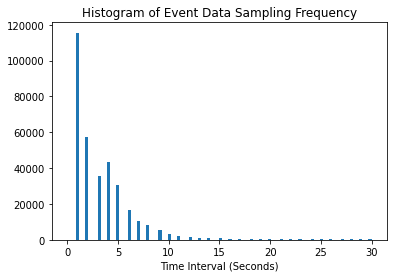

In [53]:
#  Histogram of heartbeat frequencies
plt.hist(
    hhdriveright_data_df.Time.diff() / np.timedelta64(1, 's'),
    range=[0, 30], 
    bins=100
)
plt.title('Histogram of Event Data Sampling Frequency')
plt.xlabel('Time Interval (Seconds)')

Text(0.5, 0, 'Time (Seconds)')

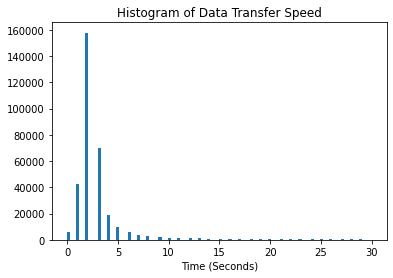

In [55]:
#  Histogram of GPS location frequencies
plt.hist(
    (hhdriveright_data_df.Received - hhdriveright_data_df.Time) / np.timedelta64(1, 's'),
    range=[0, 30], 
    bins=100
)
plt.title('Histogram of Data Transfer Speed')
plt.xlabel('Time (Seconds)')

In [74]:
hhdriveright_data_df[~hhdriveright_data_df.eco_value.isna()]['eco_value'].value_counts()

12647.0     4884
0.0         1321
0.28        1176
-0.002       847
0.002        837
            ... 
15:53:19       1
15:49:47       1
15:48:02       1
15:45:02       1
0.94           1
Name: eco_value, Length: 3556, dtype: int64

In [75]:
hhdriveright_data_df[~hhdriveright_data_df.harsh_accel.isna()]['harsh_accel'].value_counts()

1.0         2623
0.0          981
0.01         764
0.027        754
0.037        720
            ... 
13:39:37       1
13:39:35       1
13:39:34       1
13:39:33       1
13:42:08       1
Name: harsh_accel, Length: 2573, dtype: int64

In [78]:
hhdriveright_data_df.program_number.value_counts()

0.000000        116279
12847.000000     89808
11873.000000     24551
12454.000000     23251
11856.000000     19168
                 ...  
29.173879            1
29.176101            1
29.178323            1
29.180545            1
31.426115            1
Name: program_number, Length: 15155, dtype: int64

In [ ]:
program_number

Text(0.5, 0, 'Speed (MPH)')

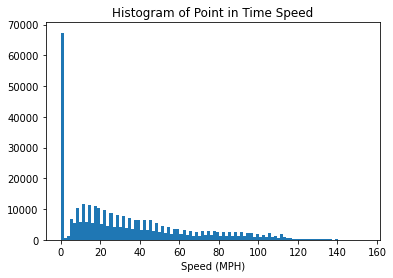

In [84]:
# Speeding
plt.hist(
    hhdriveright_data_df['Speed'],
    # range=[0, 30], 
    bins=100
)
plt.title('Histogram of Point in Time Speed')
plt.xlabel('Speed (MPH)')

In [90]:
hhdriveright_data_df['Speed Limit'].isna().sum()

349463

In [91]:
hhdriveright_data_df.columns

Index(['Time', 'Received', 'Active', 'Lat', 'Lon', 'Altitude', 'Accuracy',
       'Location', 'Speed', 'Speed Limit', 'Heading', 'priority', 'eventId',
       'ignition', 'moving', 'motion_start', 'gsm_signal', 'sleep',
       'gnss_status', 'battery_perc', 'vehicle_speed', 'fuel_level_perc',
       'battery_level', 'power_voltage', 'battery_voltage', 'battery_current',
       'x', 'y', 'z', 'eco_score', 'total_mileage', 'program_number',
       'movement', 'odo_counter', 'hours_00_counter', 'idle_counter',
       'motion_end', 'nudge', 'eco_type', 'harsh_accel', 'eco_value',
       'eco_duration', 'harsh_corner', 'harsh_brake', 'unplug',
       'power_reconnect', 'power_disconnect'],
      dtype='object')

In [94]:
hhdriveright_data_df['motion_start'].value_counts()

1.000000      42887
0.000000        147
441.277385       94
133.318991       77
352.163734       70
              ...  
220.755634        1
220.769550        1
220.789204        1
220.831577        1
296.324208        1
Name: motion_start, Length: 13034, dtype: int64